# View Calspec Observed flux in AuxTel

- Author : Sylvie Dagoret-Campagne
- Creation : 27 september 2019
- Update : April 20th 2020 for package PhotomCorrectAuxTel (not using libradtran)
- Update : August 21th 2020 adapt for libradtran simulation with the libradtran inside this PhotomCorrectAuxTel package 

For Hologram, here **the second order is added on the observed spectrum**.

Here we may run or not run atmospheric simulation with libradtran, but use already done simulation


Last verification : December 14th 2021 --> OK

In [1]:
import os,sys
import numpy as np

In [2]:
from astropy.table import Table
from astropy.io import fits

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [4]:
import pysynphot as S

In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [6]:
import scipy.special as sp

In [7]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(14,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Initialisation

## Simulation of atmosphere

In [8]:
FLAG_LIBRADTRAN=True

In [9]:
if FLAG_LIBRADTRAN:
    PATH_ATMTRANSPSIM='../libradtransim'
    PATH_ATMTRANSPSIM='../../tools/libradtran'
    sys.path.append(PATH_ATMTRANSPSIM)
else:
    PATH_ATMDATADIR="../../data/atm"
    sys.path.append(PATH_ATMDATADIR)

In [10]:
!ls ../../tools/libradtran

2021-12-13_multiabtransmissionvsairmass.png
2021-12-13_multitransmission.png
IC.DAT
README.md
SimuRT_AbsPattern_py3.ipynb
SimuRT_Verbose_py3.ipynb
SimuRT_py3.ipynb
SimuRT_vsairmass_py3.ipynb
UVspec3.py
__pycache__
info_verbose
libsimulateVisible.py
libsimulateVisible_pdm.py
randomseed
simulations


## Simulation Quantum Efficiency

In [11]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

## Import

In [12]:
import libLSSTFiltersKG as lsst

liblsstfilter_path= /Users/sylvie/MacOSX/GitHub/LSST/PhotomCorrectAuxTel/examples_SED/calspec/../../data/lsst/LSSTFiltersKG


In [13]:
if FLAG_LIBRADTRAN:
    #import libsimulateTranspLSSTScattAbsAer3 as atm
    import libsimulateVisible as atm

libradtranpath= /Users/sylvie/MacOSX/External/libRadtran2/


# Read the required data

## Read the CALSPEC Table

In [14]:
t=Table.read('table_summary_calspec_hd.fits')

In [15]:
print(t)

OBJNAME          RA                 DEC           SP_TYPE    SP_QUAL        magV                FILES         
-------- ------------------ ------------------- ------------ ------- ------------------ ----------------------
HD009051 22.193760833333332 -24.340400833333334   G6/8IIIwF5       D  8.920000076293945 hd009051_stis_005.fits
HD031128  73.04129041666667           -27.06415       F3/5Vw       D  9.140000343322754 hd031128_stis_005.fits
HD074000        130.2116825 -16.345142499999998           F2       D   9.65999984741211 hd074000_stis_005.fits
HD101452 175.05687874999995  -39.14657611111111 A2/3(m)A8-F2       E  8.199999809265137 hd101452_stis_002.fits
HD106252 183.37295833333332  10.041635555555555           G0       E                 -- hd106252_stis_005.fits
HD111980 193.31271999999998 -18.522224722222223          F7V       C  8.380000114440918 hd111980_stis_005.fits
HD115169 198.94745124999997 -29.505884444444444          G3V       C  9.199999809265137 hd115169_stis_002.fits
H

In [16]:
NBFILES=len(t)

## Add visibility flag

In [17]:
FLAG_VISIBILITY= [True] * NBFILES

In [18]:
t_vis=t

In [19]:
t_vis["vis"]=FLAG_VISIBILITY

In [20]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

## Read all spectra

In [21]:
all_sed=[]
all_label=[]
idx=0
for filename in t_vis["FILES"]:
    
    fullfilename=os.path.join(path_sed_calspec,filename)
    spec=S.FileSpectrum(fullfilename)
    
    spec.convert('photlam')
    spec.convert('nm') 
    label=str(t_vis["OBJNAME"][idx]) +" ( "+ str(t_vis["SP_TYPE"][idx]) +" )"
       
    all_sed.append(spec)
    all_label.append(label)
        
    idx+=1

Warning, 17 of 6234 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
Warning, 29 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 64 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 62 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.
Warning, 6 of 7206 bins contained negative fluxes; they have been set to zero.
Warning, 18 of 6261 bins contained negative fluxes; they have been set to zero.
Warning, 47 of 7207 bins contained negative fluxes; they have been set to zero.
Warning, 46 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 64 of 7206 bins contained negative fluxes; they have been set to zero.
Warning, 28 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6261 bins contained negative

## Get Atmosphere

In [22]:
if FLAG_LIBRADTRAN:
    am=1.
    pwv=2.
    ozone=0.
    pressure=0
    lambda0_aerosol=500.
    tau_aerosol=0.
    cloud_ext=0
    
    ##### --- call to libradtran
    # OLD : path,thefile=atm.ProcessSimulationaer(am,pwv,ozone,lambda0_aerosol,tau_aerosol)
    # NEW def ProcessSimulationaer(airmass_num, pwv_num, oz_num, aer_num, press_num, prof_str='us', proc_str='sa')

    # old
    #path, thefile = atm.ProcessSimulationaer(am, pwv, ozone,tau_aerosol,0)
    #
    
    # copy IC.dat locally
    path,thefile=atm.ProcessSimulation(am,pwv,ozone,pressure,
                                                      prof_str='us',proc_str='sa',cloudext=cloud_ext)

    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1] 

In [23]:
if FLAG_LIBRADTRAN:
    am=1.
    pwv=10.
    ozone=600.
    lambda0_aerosol=500.
    tau_aerosol=0.15
    
    ##### --- call to libradtran
    # OLD : path,thefile=atm.ProcessSimulationaer(am,pwv,ozone,lambda0_aerosol,tau_aerosol)
    # NEW def ProcessSimulationaer(airmass_num, pwv_num, oz_num, aer_num, press_num, prof_str='us', proc_str='sa')

    path, thefile = atm.ProcessSimulationaer(am, pwv, ozone,tau_aerosol,0)

    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm2=atm_data[:,0]
    tr_atm2=atm_data[:,1] 

In [24]:
if not FLAG_LIBRADTRAN:
    """
    Read all fits files, extract images, glue images alltogether and find the best and worse atmosphere
    """
    atmospheric_basename_files=os.listdir(PATH_ATMDATADIR)
    
    idx=0
    all_data=[]
    all_hdr=[]
    all_wl=[]
    for file in atmospheric_basename_files:
        inputfile=os.path.join(PATH_ATMDATADIR,file)
        hdu = fits.open(inputfile)
        all_hdr.append(hdu[0].header)
        all_data.append(hdu[0].data[1:,:])
        all_wl.append(hdu[0].data[0,:])
        idx+=1
        hdu.close()
        
    data=np.vstack(all_data)
    hdr=all_hdr[0]
    
    
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    vaod=data[1:,idx_out_vaod] # vertical aerosol depth
    pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[1:,idx_out_o3]     # ozone
    cld=data[1:,idx_out_cld]   # clouds (not used)
    
    wl_atm=all_wl[0][idx_out_res:]
    transm=data[:,idx_out_res:]
    

    NBSIM=transm.shape[0]
    
    transmsum=np.zeros(NBSIM)
    for idx in np.arange(NBSIM):
        transmsum[idx]=transm[idx,:].sum()
        
    idx_best_atm=np.where(transmsum==transmsum.min())[0][0]
    idx_worse_atm=np.where(transmsum==transmsum.max())[0][0]
    
    tr_atm=transm[idx_best_atm,:]
    tr_atm2=transm[idx_worse_atm,:]

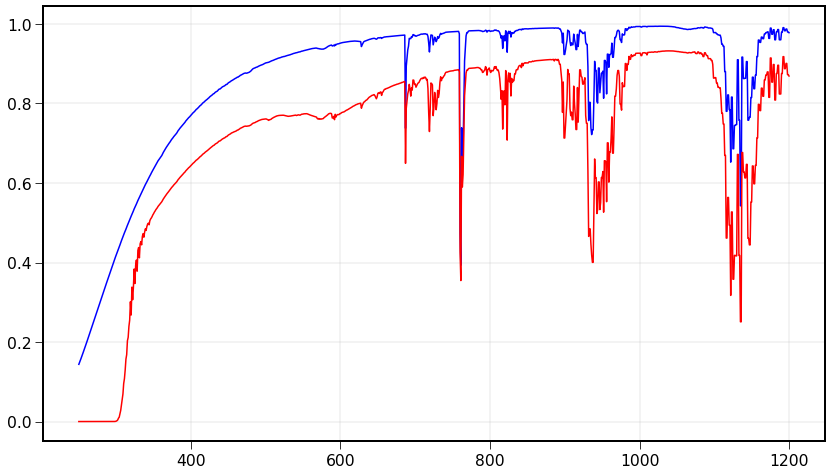

In [25]:
plt.plot(wl_atm,tr_atm,'b-')
plt.plot(wl_atm,tr_atm2,'r-')

plt.grid()

In [26]:
bp_atm= S.ArrayBandpass(wl_atm*10.,tr_atm, name="atm")

## Get Quantum Efficiency

In [27]:
!ls $PATH_LSSTFiltersKGDATA

LSST-G.xls                LSST-Y4.kg.xls            ideal_r.txt
LSST-I (version 1).xls    LSST-Y4_kg.xls            ideal_u.txt
LSST-I.xls                LSST-Z (version 1).xls    ideal_y4.txt
LSST-R.xls                LSST-Z.xls                ideal_z.txt
LSST-ThroughputCCD.xlsx   MirrorsThroughput.xlsx    lsst_mirrorthroughput.txt
LSST-U (version 1).xls    ideal_g.txt
LSST-U.xls                ideal_i.txt


In [28]:
wl,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


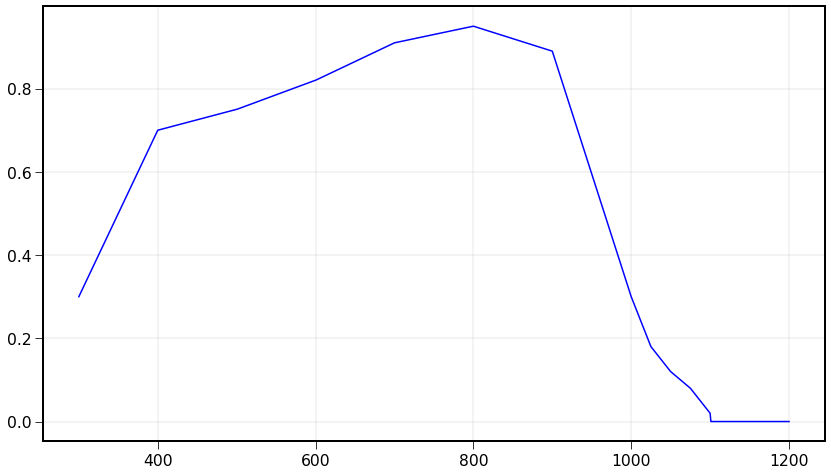

In [29]:
plt.plot(wl,ccdqe,"b-")
plt.grid()

In [30]:
bp_qe= S.ArrayBandpass(wl*10.,ccdqe, name='QE')

## Get transmission QE and Atmosphere

In [31]:
bp_qeatm=bp_atm*bp_qe

# Build the observed spectra

## Without Hologram efficiency

((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The wa

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_60529/736122649.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])


Text(0.5, 1.0, 'Observed spectra - Flat disperser transmission')

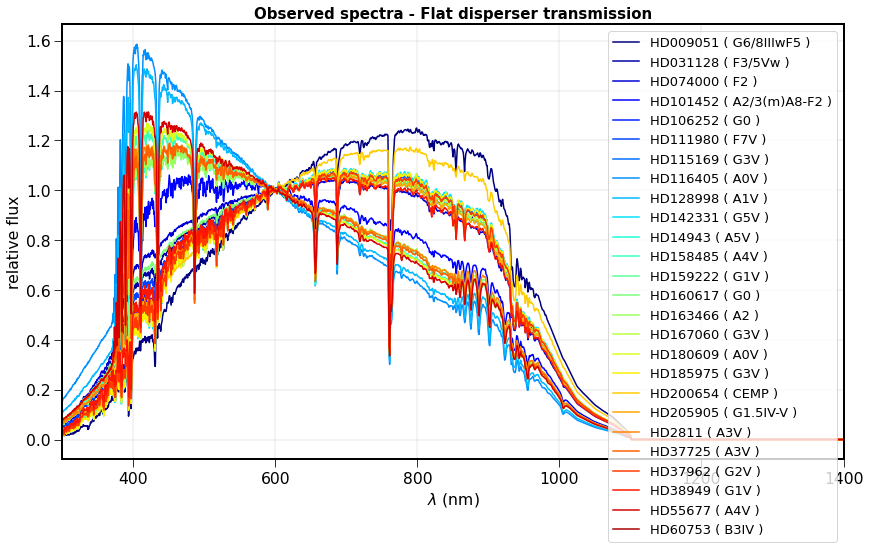

In [32]:
idx=0
all_obs=[]
for sed in all_sed:
    obs = S.Observation(sed, bp_qeatm,force='taper')
    
    wl_idx=np.argmin(np.abs(obs.binwave-6000))
    color=all_colors[idx]
    
    plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])
    
    all_obs.append(obs)
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("relative flux")
plt.grid()
plt.title("Observed spectra - Flat disperser transmission",fontsize=15)

## With Theoretical Hologram Efficiency

- Here we take the theoretical hologram efficiency instead of the measured true efficiency

In [33]:
X0=1000
X=wl
X2=np.sort(np.unique(np.concatenate((wl/2,wl)))) # X2 need to have small wavelength
#X2=np.arange(10,45000,1)
Eff_holo=sp.jv(1, X0/X)**2
Eff_holo2=sp.jv(2, X0/X2)**2

Text(0.5, 0, '$\\lambda$ (nm)')

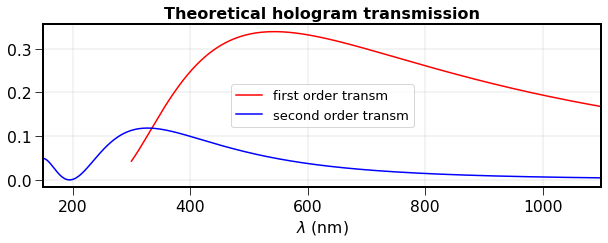

In [34]:
fig = plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
ax.plot(wl,Eff_holo,"r-",label="first order transm")
ax.plot(X2,Eff_holo2/2,"b-",label="second order transm")
ax.set_xlim(150,1100)
ax.grid()
ax.legend()
ax.set_title("Theoretical hologram transmission")
ax.set_xlabel("$\lambda$ (nm)")

In [35]:
bp_holo= S.ArrayBandpass(wl*10.,Eff_holo, name='Holo')
bp_holo_order2= S.ArrayBandpass(X2*10.,Eff_holo2, name='Holo2')

In [36]:
bp_all=bp_qeatm*bp_holo
bp_all2=bp_qeatm*bp_holo_order2

(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inste

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_60529/1953370961.py:11: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])


Text(0.5, 1.0, 'Observed spectra - Hologram disperser transmission : $X_0$= 1000 nm')

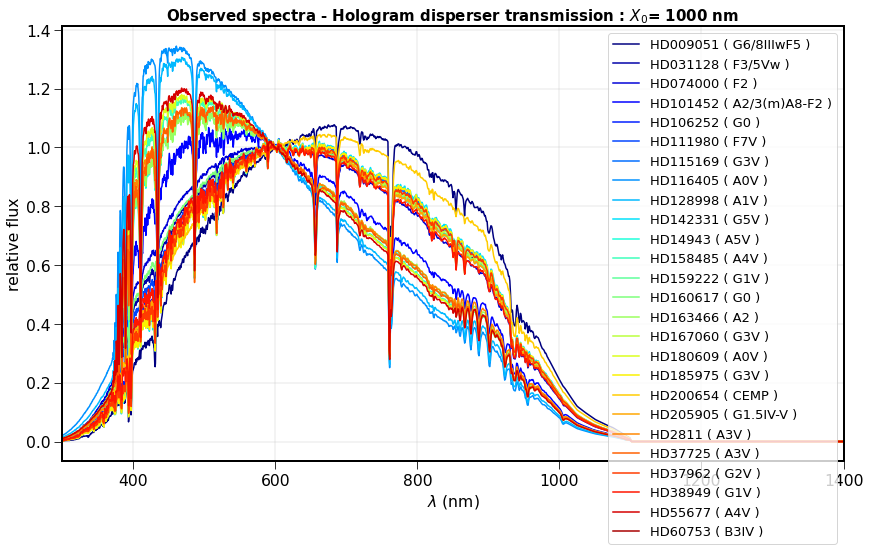

In [37]:
idx=0
all_obs=[]
all_obs2=[]
for sed in all_sed:
    obs = S.Observation(sed, bp_all,force='taper') # order 1
    obs2 = S.Observation(sed, bp_all2,force='taper') # order 2
    
    wl_idx=np.argmin(np.abs(obs.binwave-6000))
    color=all_colors[idx]
    
    plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])
    
    all_obs.append(obs)
    all_obs2.append(obs2)
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("relative flux")
plt.grid()
title="Observed spectra - Hologram disperser transmission : $X_0$= {:d} nm".format(X0)
plt.title(title,fontsize=15)

## Add order 2

In [38]:
from scipy import interpolate

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_60529/136174674.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(2*obs2.binwave/10.,obs2.binflux/2/obs1.binflux[wl_idx],color=color,label=all_label[idx])
/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_60529/136174674.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(2*obs2.binwave/10.,func_order2(2*obs2.binwave)/obs1.binflux[wl_idx],":",color=color)


Text(0.5, 1.0, 'Observed second order spectra - Hologram disperser transmission : $X_0$= 1000 nm')

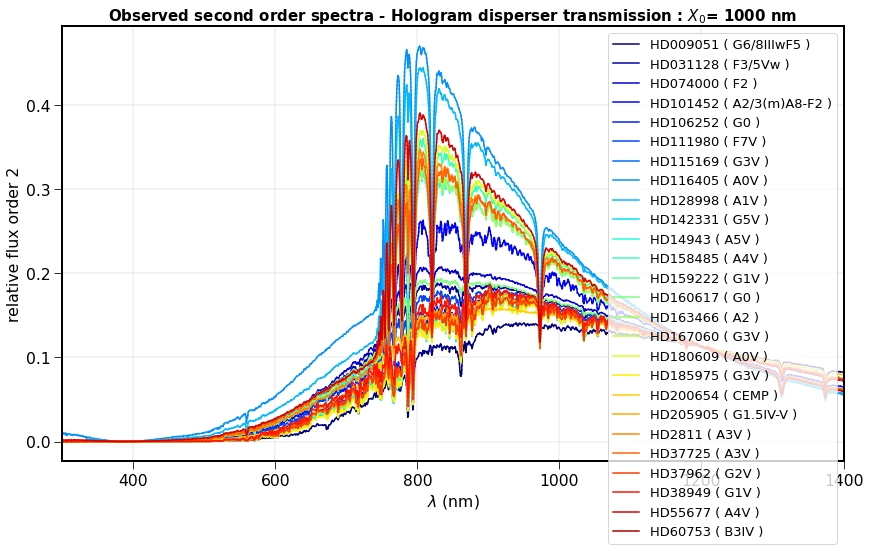

In [39]:
idx=0
all_func=[]

# loop on both simulation
for obs1,obs2 in zip(all_obs,all_obs2):

    color=all_colors[idx]
    wl_idx=np.argmin(np.abs(obs1.binwave-6000))
    # shift wavelength by two
    # divide the flux by 2
    
    theX=2*obs2.binwave
    theY=obs2.binflux/2
    
    func_order2 = interpolate.interp1d(theX,theY,fill_value=0 )
    
    plt.plot(2*obs2.binwave/10.,obs2.binflux/2/obs1.binflux[wl_idx],color=color,label=all_label[idx])
    plt.plot(2*obs2.binwave/10.,func_order2(2*obs2.binwave)/obs1.binflux[wl_idx],":",color=color)
    
    all_func.append(func_order2)
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("relative flux order 2")
plt.grid()
title="Observed second order spectra - Hologram disperser transmission : $X_0$= {:d} nm".format(X0)
plt.title(title,fontsize=15)

# Show both orders

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_60529/377725859.py:26: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(obs1.binwave/10.,component_sum/obs1.binflux[wl_idx],color=color,label=all_label[idx])


Text(0.5, 1.0, 'Observed first and second order spectra - Hologram disperser transmission : $X_0$= 1000 nm')

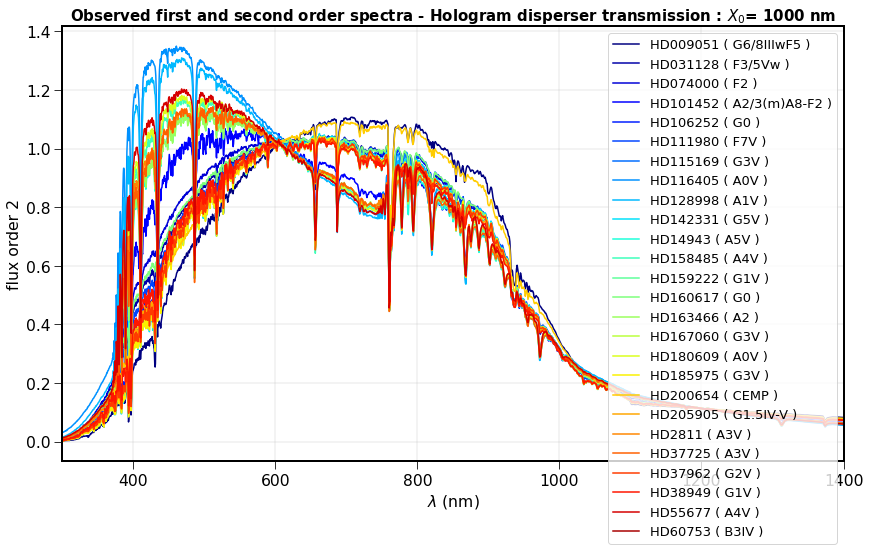

In [40]:
idx=0

# loop on both simulation
for obs1,obs2 in zip(all_obs,all_obs2):

    color=all_colors[idx]
    wl_idx=np.argmin(np.abs(obs1.binwave-6000))
    # shift wavelength by two
    # divide the flux by 2
    
    wl_idx=np.argmin(np.abs(obs1.binwave-6000))
    component_order1=obs1.binflux
    
    #func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,fill_value=0)
    
    theX=2*obs2.binwave
    theY=obs2.binflux/2
    
    func_order2 = interpolate.interp1d(theX,theY,bounds_error=False,fill_value=(0,0))
    

    
    component_order2=func_order2(obs1.binwave)
    component_sum=component_order1+component_order2
    
    plt.plot(obs1.binwave/10.,component_sum/obs1.binflux[wl_idx],color=color,label=all_label[idx])
    
   
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("flux order 2")
plt.grid()
title="Observed first and second order spectra - Hologram disperser transmission : $X_0$= {:d} nm".format(X0)
plt.title(title,fontsize=15)

# Play Single spectra but many possible theoretical hologram transmissions

In [41]:
sed_idx=0

In [42]:
the_sed=all_sed[sed_idx]
the_sed_name=label=t_vis["OBJNAME"][sed_idx]+" ( "+t_vis["SP_TYPE"][sed_idx]+" )"

In [43]:
# different hypothesis on the hologram parameter
ALL_X0=np.arange(700.,1200.,100)
NX0=len(ALL_X0)

In [44]:
cNorm = colors.Normalize(vmin=0, vmax=NX0)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NX0), alpha=1)

In [45]:
all_eff=[]
X=wl
all_label=[]
for X0 in ALL_X0: 
    Y=sp.jv(1, X0/X)**2
    all_eff.append(Y)
    label="$X_0$ = {} nm".format(X0)
    all_label.append(label)

In [46]:
all_bp_effholo=[]
for idx in np.arange(NX0):
    bp_holo= S.ArrayBandpass(wl*10.,all_eff[idx], name=all_label[idx])
    all_bp_effholo.append(bp_holo)

((((atm * QE) * Holo) * $X_0$ = 700.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 800.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 900.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 1000.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 1100.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


Text(0.5, 1.0, 'Observed spectra for SED HD009051 ( G6/8IIIwF5 ) - Theoretical Hologram disperser transmission ')

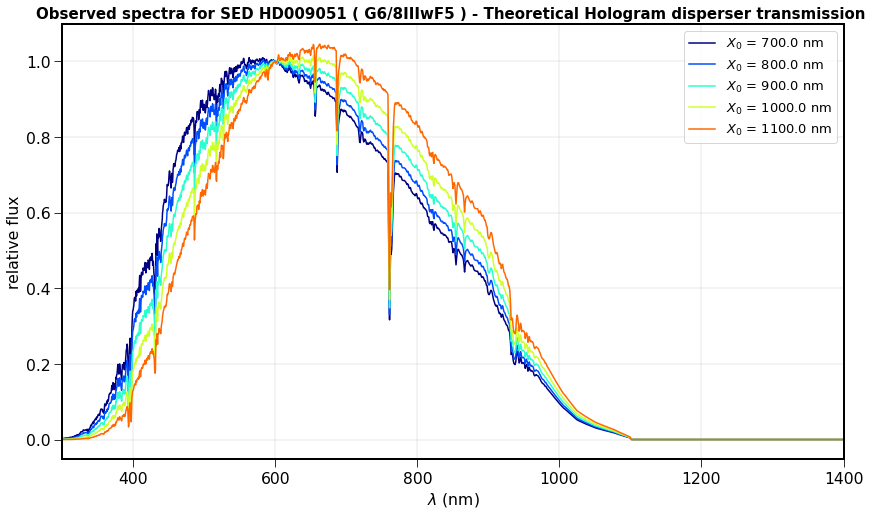

In [47]:
idx=0
all_obs=[]
for idx in np.arange(NX0):
    
    bp_all_holo=bp_all*all_bp_effholo[idx]
    obs = S.Observation(the_sed, bp_all_holo,force='taper')
    
    wl_idx=np.argmin(np.abs(obs.binwave-6000))
    color=all_colors[idx]
    
    plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])
    
    all_obs.append(obs)
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("relative flux")
plt.grid()
title="Observed spectra for SED {} - Theoretical Hologram disperser transmission ".format(the_sed_name)
plt.title(title,fontsize=15)